Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \delta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + (\eta - 1) (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{\delta \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
# Incoming radiation
Q0 = 342.5
## land fraction and albedo
#Fraction of land on the planet
p = 0.3

## outgoing radiation linearized
kappa  = 1.74
Tkappa = - 119.15
# Greenhouse effect parameter
B = 5.35 # a in the notes, CO2 radiative forcing

## Volcanism emissions
Volcan = 0.05964

Ts =   9.72
Cs = 587.40 # Average carbon with no Ca

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035 # λ in the notes, Oceanic pump modulation parameter
cearth = 0.107 # heat capacity
tauc = 20
coc0 =  745.5 # initial oceanic carbon stock
## Ocean albedo parameters, in celsius
Talphaocean_low  = - 54.15
Talphaocean_high = 25.85
alphaocean_min   = 0.255
alphaocean_max   = 0.84


Cbio_low  = 106.5 # Gt
Cbio_high = 1491 # Gt

T0 = 24.85
C0 = 596.5 # reference CO2 level, in Gt

## CO2 uptake by vegetation
wa       = 0.03195 # Gt/yr
vegcover = 0.4 # Av in notes

Thigh = 41.85
Tlow  =  8.85
Topt1 = 21.85
Topt2 = 36.85
acc   = 5


# Ocean albedo
def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [3]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 532.5
C_max  = 1065
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 10 # 10. avaoid 
F_max = 5325. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 55, 108)

In [4]:
To = 9.72 # Mean with no anthropogenic carbon emissions, in Cᵒ

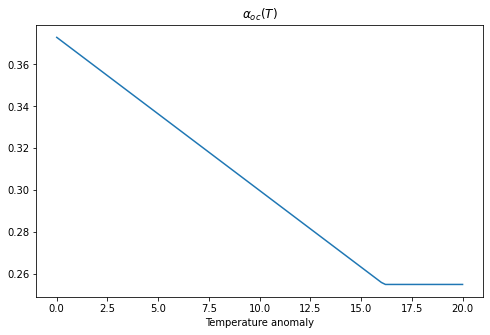

(0.255, 0.37295062500000004)

In [5]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

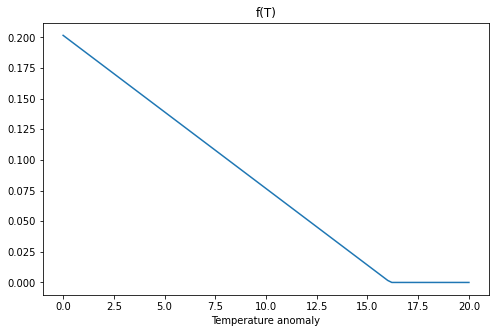

(0.0, 0.20162499999999994)

In [6]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

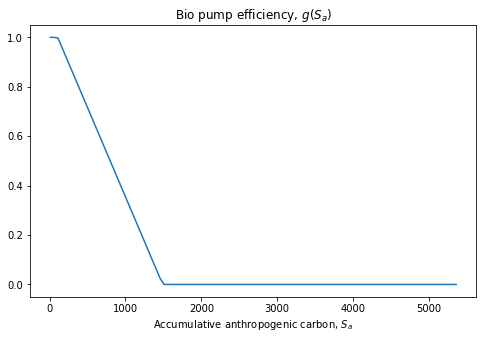

In [7]:
bio_pump_efficiency = biopump(F_grid)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

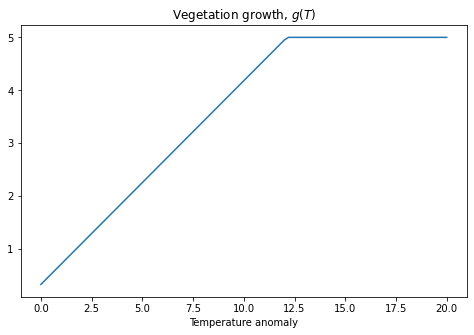

(0.334615384615385, 5.0)

In [8]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

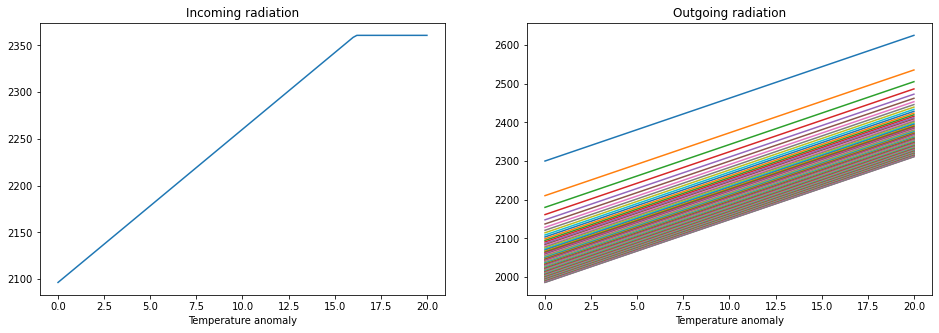

In [9]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :])
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

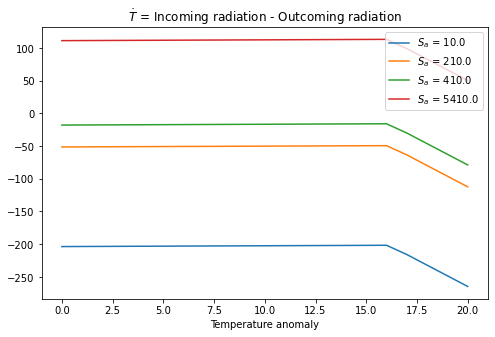

In [38]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :])
plt.plot(T_grid, (ri - ro)[:, [0, 1,2, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

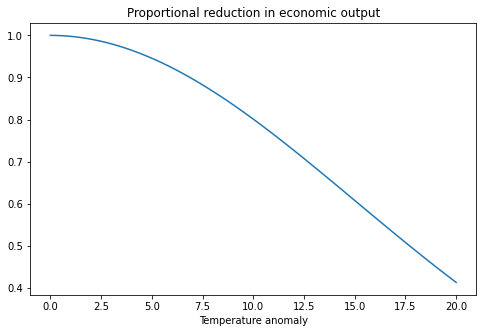

In [13]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [89]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = -10. 
T_max  = 20. # 
hT     = 1.
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 532.5
C_max  = 1065
hC     = 20.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 10 # 10. avaoid 
F_max = 5325. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 200.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(31, 28, 28)

In [98]:
v0 =  -  eta * F_mat

dG  = gamma_1 + gamma_2 * T_mat

epsilon  = 0.01
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 100
fraction = 0.01


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)

        

    Ca = - eta * delta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
       
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + T0) - Ro(T_mat + T0, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * (C_mat) * vegcover * veggrowth(T_mat +T0)
    B2 += oceanatmphysflux(T_mat + T0) * (1 - fracseaice(T_mat + T0))
    B2 += oceanbioflux(T_mat + T0, F_mat, sa) * (1 - fracseaice(T_mat + T0))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + T0))
    B3 = Ca
    C1 = 0. * np.ones(T_mat.shape)
    C2 = 0. * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration %s: False Transient Error: %s; PDE Error %s" % (count, lhs_error, rhs_error))

print("Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

Iteration 1: False Transient Error: 22.0787495867512; PDE Error 28.351784160487465
Iteration 2: False Transient Error: 17.30888678442568; PDE Error 22.078750203927545
Iteration 3: False Transient Error: 13.678324174318846; PDE Error 17.308886380627364
Iteration 4: False Transient Error: 10.911759972904633; PDE Error 13.678324657479495
Iteration 5: False Transient Error: 8.800868017510766; PDE Error 10.911759040636735
Iteration 6: False Transient Error: 7.189615162184282; PDE Error 8.800867280768752
Iteration 7: False Transient Error: 6.014057324529176; PDE Error 7.189558442011126
Iteration 8: False Transient Error: 5.136939246534666; PDE Error 6.014001259085468
Iteration 9: False Transient Error: 4.450798877286388; PDE Error 5.1369395274354765
Iteration 10: False Transient Error: 3.9120567640622994; PDE Error 4.450799344743903
Iteration 11: False Transient Error: 3.4874881997126295; PDE Error 3.912057013504768
Iteration 12: False Transient Error: 3.1516116230335456; PDE Error 3.4874883

Iteration 100: False Transient Error: 1.7902485961400316; PDE Error 1.7959110503514415
Total iteration 100: LHS Error: 1.7902485961400316; RHS Error 1.7959110503514415


In [99]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max()

(32.078747566014044,
 -311.90145271173833,
 -171.61670149327847,
 -85.62726340678603,
 0.583013430312728,
 0.010015717507173765,
 0.010649567323255825)

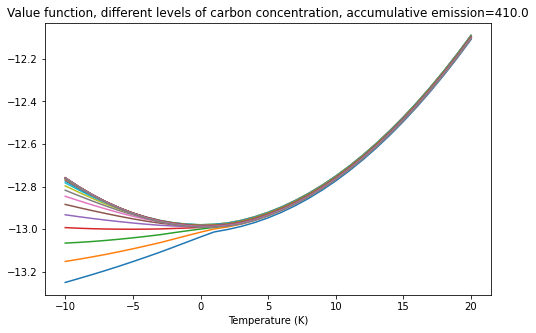

In [109]:
ii = 2
plt.plot(T_grid, v0[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

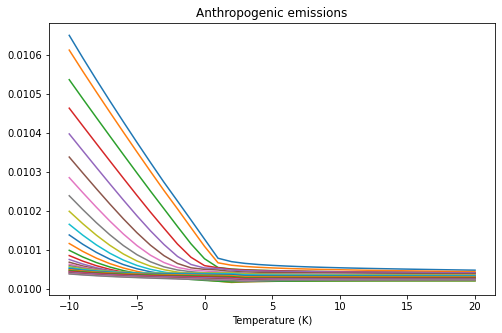

In [111]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

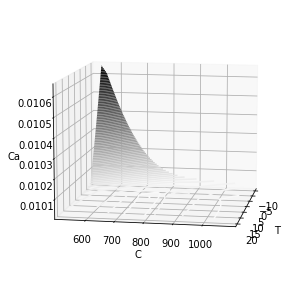

In [112]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [103]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 =   9.72 + 1.1
C_0 = 587.40
F_0 = 870 - 580

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 1.0, 'Emission')

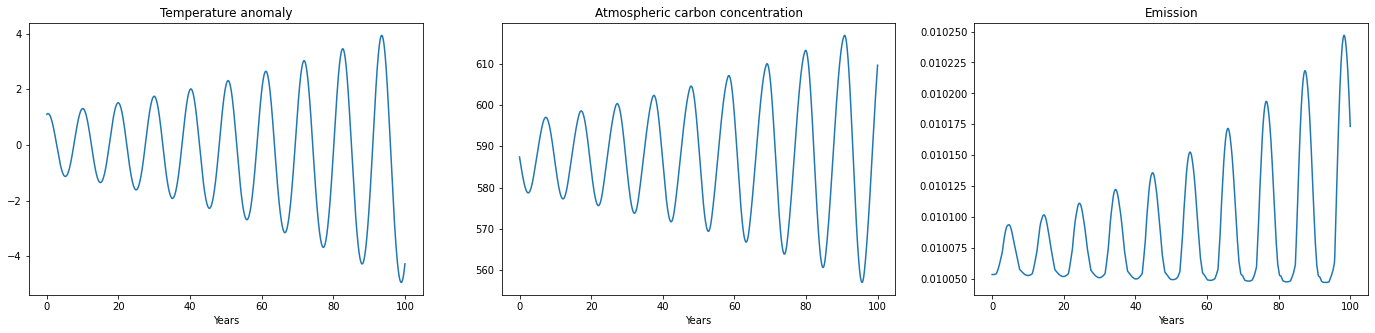

In [117]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission")